In [1]:
import numpy as np
import pandas as pd
import os
import PIL
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import shutil
from sklearn.metrics import confusion_matrix, classification_report

In [2]:

def squash(x, axis=-1):
    s_squared_norm = tf.math.reduce_sum(tf.math.square(x), axis, keepdims=True) + keras.backend.epsilon()
    scale = tf.math.sqrt(s_squared_norm) / (1 + s_squared_norm)
    return scale * x


def margin_loss(y_true, y_pred):
    lamb, margin = 0.5, 0.1
    return tf.math.reduce_sum((y_true * tf.math.square(tf.nn.relu(1 - margin - y_pred)) + lamb * (
        1 - y_true) * tf.math.square(tf.nn.relu(y_pred - margin))), axis=-1)



In [3]:
# we added the separation and header because the data is not organized, one can run without sep and header
#to understand the difference

train_df = pd.read_csv('../input/covidx-cxr2/train.txt', sep=" ", header=None)

#Columns are added because it was seen that column names were 0,1,2,3, so new column names are added
#which are given in descriptions
train_df.columns=['patient id', 'filename', 'class', 'data source']

# Since we are doing image classification, patient id and data source is of no importance to us, so
#we cn drop them
train_df=train_df.drop(['patient id', 'data source'], axis=1 )

#same as train
test_df = pd.read_csv('../input/covidx-cxr2/test.txt', sep=" ", header=None)
test_df.columns=['id', 'filename', 'class', 'data source' ]
test_df=test_df.drop(['id', 'data source'], axis=1 )

In [4]:
print(train_df['class'].value_counts()/train_df['class'].count())
print(test_df['class'].value_counts()/test_df['class'].count())

positive    0.533382
negative    0.466618
Name: class, dtype: float64
positive    0.5
negative    0.5
Name: class, dtype: float64


In [5]:
train_df, valid_df = train_test_split(train_df, train_size=0.8, random_state=0)

In [6]:
print("---train---")
print(train_df['class'].value_counts())
print("---valid---")
print(valid_df['class'].value_counts())
print("---test---")
print(test_df['class'].value_counts())

---train---
positive    12779
negative    11209
Name: class, dtype: int64
---valid---
positive    3215
negative    2783
Name: class, dtype: int64
---test---
positive    200
negative    200
Name: class, dtype: int64


In [7]:
train_path = '../input/covidx-cxr2/train/'  #directory path
test_path = '../input/covidx-cxr2/test/'

In [8]:
train_path+'filename'

'../input/covidx-cxr2/train/filename'

(631, 790, 3)


2022-09-26 13:13:43.375557: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
Cleanup called...


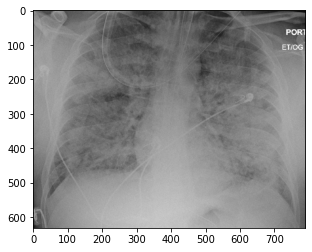

In [9]:
image = tf.io.decode_image(tf.io.read_file(train_path+train_df['filename'][0]), channels=3)
print(image.shape)
plt.imshow(image)


In [10]:
train_datagen = ImageDataGenerator(rescale = 1.0/255.)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

In [11]:
train_gen = train_datagen.flow_from_dataframe(dataframe = train_df, directory=train_path, x_col='filename', 
                                              y_col='class', target_size=(128,128), batch_size=32, 
                                               class_mode='binary')
valid_gen = test_datagen.flow_from_dataframe(dataframe = valid_df, directory=train_path, x_col='filename',
                                             y_col='class', target_size=(128,128), batch_size=32, 
                                            class_mode='binary')
test_gen = test_datagen.flow_from_dataframe(dataframe = test_df, directory=test_path, x_col='filename', 
                                            y_col='class', target_size=(128,128), batch_size=32,
                                             class_mode='binary')

Found 23988 validated image filenames belonging to 2 classes.
Found 5998 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.


In [12]:
""" for step, (x, y) in enumerate(test_gen):
    print(step,x.shape,y.shape) """

' for step, (x, y) in enumerate(test_gen):\n    print(step,x.shape,y.shape) '

In [13]:
X,y=train_gen.next()

In [14]:
margin_loss(y,y)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [16]:
X.shape

(32, 128, 128, 3)

In [17]:
y

array([0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1.,
       1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1.],
      dtype=float32)

In [19]:
c1=tf.keras.layers.Conv2D(16,kernel_size=5,strides=2,padding='valid',activation='relu')
c2=tf.keras.layers.Conv2D(32,kernel_size=5,strides=2,padding='valid',activation='relu')
c3=tf.keras.layers.Conv2D(64,kernel_size=5,strides=2,padding='valid',activation='relu')
c4=tf.keras.layers.Conv2D(128,kernel_size=5,strides=1,padding='valid',activation='relu')
dc1=tf.keras.layers.DepthwiseConv2D(kernel_size=9,strides=(1, 1),padding='valid',activation='relu')

In [20]:
z=c4(c3(c2(c1(X))))
z=dc1(z)
print(z.shape)

(32, 1, 1, 128)


In [21]:
z=tf.reshape(z,[32,16,8])

In [22]:
print(z.shape)


(32, 16, 8)


In [33]:
print(c1.count_params(),c2.count_params())

1216 12832


In [23]:

class Capsule(keras.layers.Layer):
   

    def __init__(self,
                 num_capsule,
                 dim_capsule,
                 routings=3,
                 **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.caps_n = num_capsule
        self.caps_dim = dim_capsule
        self.r = routings

    def get_config(self):
        config = super().get_config().copy()
        config.update({
        'num_capsule':  self.caps_n,
        'dim_capsule' : self.caps_dim,
        'routings':  self.r,      
        })
        return config

    def build(self, input_shape):
        
        self.W = self.add_weight(name='W',
                    shape=[1, input_shape[1], self.caps_n, self.caps_dim, input_shape[-1]],
                    dtype=tf.float32,
                    initializer='glorot_uniform',
                    trainable=True)

    def call(self, input_tensor):
        batch_size = input_tensor.shape[0]
        W_tiled = tf.tile(self.W, [batch_size, 1, 1, 1, 1]) # replicating the weights for parallel processing of a batch.
        """ W_tiled.shape=[batch_size,caps_n(i-1),caps_n(i),caps_dim(i),caps_dim(i-1)] """

        caps_output_expanded = tf.expand_dims(input_tensor, -1) # converting last dim to a column vector.
        """ the above step change the input shape from 
            [batch_size,caps_n(i-1),caps_dim(i-1)] --> [batch_size,caps_n(i-1),caps_dim(i-1),1]"""

        caps_output_tile = tf.expand_dims(caps_output_expanded, 2)
        """ the above step change the input shape from 
            [batch_size,caps_n(i-1),caps_dim(i-1),1] --> [batch_size,caps_n(i-1),1,caps_dim(i-1),1]"""

        caps_output_tiled = tf.tile(caps_output_tile, [1, 1, self.caps_n, 1, 1]) # replicating the input capsule vector for every output capsule.
        """ i.e [batch_size,caps_n(i-1),1,caps_dim(i-1),1] --> [batch_size,caps_n(i-1),caps_n(i),1,caps_dim(i-1),1]"""

        caps_predicted = tf.matmul(W_tiled, caps_output_tiled) # this is performing element wise tf.matmul() operation.
        """ caps_predicted.shape = [1,caps_n(i-1),caps_n(i),caps_dim(i),1]"""

        """ dynamic routing """
        raw_weights = tf.zeros([batch_size,input_tensor.shape[1] , self.caps_n, 1, 1]) # non trainable weights.
        """ raw_weights.shape=[batch_size,caps_n(i-1) ,caps_n(i), 1, 1]"""

        r=self.r
        while(r):
          r-=1
          routing_weights = tf.nn.softmax(raw_weights,axis=2)
          """ [batch_size,caps_n(i-1) ,caps_n(i), 1, 1]  softmax applied along the pointed dim.
                                           ^                                                   """

          weighted_predictions = tf.multiply(routing_weights, caps_predicted)
          """ weighted_predictions.shape = [batch_size, caps_n(i-1),caps_n(i),caps_dim(i), 1]"""

          weighted_sum = tf.reduce_sum(weighted_predictions, axis=1, keepdims=True)
          """ [batch_size,caps_n(i-1) ,caps_n(i),caps_dim(i), 1]  sum applied along the pointed dim.
                               ^                                                               
          therefore weighted_sum.shape=[batch_size,1 ,caps_n(i),caps_dim(i), 1]"""

          v = squash(weighted_sum, axis=-2) #normalize to unit length vector.
          v_tiled = tf.tile(v, [1, input_tensor.shape[1], 1, 1, 1])
          """ v_tiled.shape=[batch_size,caps_n(i-1),caps_n(i),caps_dim(i), 1]"""

          agreement = tf.matmul(caps_predicted, v_tiled,transpose_a=True)
          """ agreement.shape=[batch_size,caps_n(i-1),caps_n(i), 1, 1]"""

          if(r>0):
              routing_weights+=agreement
          else:
              return v

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)

In [24]:
model=Capsule(32,16)

In [36]:
model.get_config()

{'name': 'capsule',
 'trainable': True,
 'dtype': 'float32',
 'num_capsule': 32,
 'dim_capsule': 16,
 'routings': 3}

In [37]:
model(z)

<tf.Tensor: shape=(32, 1, 32, 16, 1), dtype=float32, numpy=
array([[[[[ 6.61846844e-09],
          [ 2.39990050e-09],
          [-1.25499016e-08],
          ...,
          [ 4.96960206e-09],
          [-1.03619180e-09],
          [-2.82681922e-09]],

         [[-1.70475118e-08],
          [-4.79804108e-09],
          [ 1.32473321e-09],
          ...,
          [ 1.23388788e-09],
          [-1.84230853e-08],
          [-5.27503774e-09]],

         [[ 1.14204664e-08],
          [ 4.89169061e-09],
          [ 3.30852234e-09],
          ...,
          [-8.53423465e-09],
          [ 6.63365762e-09],
          [-4.74339323e-09]],

         ...,

         [[ 6.75307144e-09],
          [ 3.65082142e-09],
          [-2.25922463e-08],
          ...,
          [-8.24395752e-09],
          [-4.39854508e-09],
          [ 1.18375514e-08]],

         [[-6.64372646e-09],
          [-1.06182583e-08],
          [-1.55732938e-08],
          ...,
          [ 2.04752160e-10],
          [-2.79152008e-08],
 

In [29]:
w=model.get_weights()

In [30]:
w[0].shape

(1, 3844, 32, 16, 256)

In [31]:
print(X.shape,y.shape,z.shape)

(32, 128, 128, 3) (32,) (32, 3844, 256)


In [43]:
model.build(z.shape)

In [47]:
tmp=np.array([[[1,0],[0,1]],[[1,0],[0,1]],
         [[1,0],[0,1]],[[1,0],[0,1]]]).reshape([2,2,2,2])

In [53]:
tmpy=np.array([[1,1],[1,1],[1,1],[1,1]]).reshape([2,2,1,2])

In [61]:
tmpy[1][0].shape

(1, 2)

In [66]:
tf.matmul(tmpy,tmp)

<tf.Tensor: shape=(2, 2, 1, 2), dtype=int64, numpy=
array([[[[1, 1]],

        [[1, 1]]],


       [[[1, 1]],

        [[1, 1]]]])>

In [29]:
model_input = keras.Input(shape=(128, 128, 3), name="img")
x=c1(model_input)
x=c2(x)
x=c3(x)
x=c4(x)
x=dc1(x)
x=tf.reshape(x,[32,16,8])
model_output = model(x)

In [30]:
encoder = keras.Model(model_input, model_output, name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 62, 62, 16)        1216      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        12832     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        51264     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 128)         204928    
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 1, 1, 128)         10496     
_________________________________________________________________
tf.reshape_1 (TFOpLambda)    (32, 16, 8)               0   